# BRDF generation
This notebook generates the Bidirectional Reflectance Distribution Functions (BRDF) used in the simulation of the single façade and the street canyon example. 


In [47]:
"""Useful functions to generate example BRDF."""
import sparrowpy as sp
import numpy as np
import os
import pyfar as pf
import sofar as sf
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.fig_formatting import create_fig,export_fig
from utils.brdf_handling import (random,
                                 add_source_receiver_data,
                                 _average_frequencies)
%matplotlib inline
basepath=os.path.join(os.getcwd(),'resources')

Define function for calculation of the equivalent RISC of a given BSC distribution

In [48]:
def calculate_srand(bsc_sources, bsc_receivers, bsc):
    r"""Calculate random-incidence scattering coefficient (RISC).

    This function calculates the RISC, or $s_\mathrm{rand}$,
    given an input bidirectional scattering coefficient (BSC) distribution.
    """
    bsc_spec = bsc_sources.copy()
    bsc_spec.azimuth += np.pi
    idx_spec = bsc_receivers.find_nearest(bsc_spec)[0][0]
    s_rand = random(
        1-bsc[np.arange(bsc_sources.csize), idx_spec],
        bsc_sources)

    return s_rand

Load simulated BSC of triangular profile surface

In [49]:
sofa_brdf = sf.read_sofa(
    os.path.join(basepath,'paper','triangle_sim_optimal.s_d.sofa'))
bsc_tri_orig, bsc_sources, bsc_receivers = pf.io.convert_sofa(sofa_brdf)
bsc_sources.weights = sofa_brdf.SourceWeights
bsc_receivers.weights = sofa_brdf.ReceiverWeights

SOFA file contained custom entries
----------------------------------
SourceWeights, ReceiverWeights, SampleStructuralWavelength, SampleStructuralWavelengthX, SampleStructuralWavelengthY, SampleModelScale, SampleDiameter, SampleSymmetryAzimuth, SampleSymmetryRotational, SampleStructuralDepth, SampleBaseplateHeight, SpeedOfSound


Determine random-incidence scattering coefficient of triangular profile surface

In [50]:
s_rand_orig = calculate_srand(bsc_sources, bsc_receivers, bsc_tri_orig)

# rescale to dimensions described in paper
s_rand_orig._frequencies /= 8

mirror BSC distribution over all quadrants

In [51]:
bsc_incident_directions = bsc_receivers.copy()
bsc_scattering_directions = bsc_receivers.copy()
bsc_mirrored = pf.FrequencyData(
    np.zeros((bsc_incident_directions.csize, bsc_scattering_directions.csize,
              bsc_tri_orig.n_bins)),
    bsc_tri_orig.frequencies)
for i_source in tqdm(range(bsc_receivers.csize)):
    # mirror results from previous directions for Azimuth > 90°
    if bsc_incident_directions[i_source].azimuth > np.pi/2:
        az_is = bsc_incident_directions[i_source].azimuth[0]
        if az_is < np.pi:  # 180:
            az_mirror = np.pi - az_is
        elif az_is < 3/2*np.pi:  # 270°
            az_mirror = np.abs(np.pi - az_is)
        else:
            az_mirror = 2*np.pi - az_is
        delta_azimuth = az_is - az_mirror

        # find the correct incident direction due to symmetry
        find_incident = pf.Coordinates.from_spherical_elevation(
            az_mirror,
            bsc_incident_directions.elevation[i_source],
            bsc_incident_directions.radius[i_source])
        i_source_mirror = bsc_incident_directions.find_nearest(
            find_incident, distance_measure='spherical_radians',
            radius_tol=1e-13)[0][0]

        # rotate the scattering data to the correct azimuth
        shifted_coords = bsc_scattering_directions.copy()
        shifted_coords.azimuth -= delta_azimuth
        idx_scattering = bsc_incident_directions.find_nearest(
            shifted_coords, distance_measure='spherical_radians',
            radius_tol=1e-13)[0]
        bsc_mirrored.freq[i_source, :, :] = bsc_tri_orig.freq[i_source_mirror,
                                                     idx_scattering, :]
    else:
        bsc_mirrored.freq[i_source, :, :] = bsc_tri_orig.freq[i_source, :, :]

bsc_sources = bsc_receivers.copy()

# rescale to dimensions described in paper
bsc_mirrored._frequencies /= 8

  0%|          | 0/484 [00:00<?, ?it/s]C:\Users\jotag\AppData\Local\Temp\ipykernel_9184\1034019500.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
  bsc_mirrored.freq[i_source, :, :] = bsc_tri_orig.freq[i_source, :, :]
C:\Users\jotag\AppData\Local\Temp\ipykernel_9184\1034019500.py:34: ComplexWarning: Casting complex values to real discards the imaginary part
  bsc_mirrored.freq[i_source, :, :] = bsc_tri_orig.freq[i_source_mirror,
100%|██████████| 484/484 [00:00<00:00, 769.12it/s] 


Reduce number of BSC incident and outgoing direction samples from 484 to 144

In [52]:
directions_bsc = pf.samplings.sph_gaussian(sh_order=11)
directions_bsc = directions_bsc[directions_bsc.z>0]

bsc_mirrored_reduced = pf.FrequencyData(
    np.zeros((directions_bsc.csize, directions_bsc.csize, bsc_mirrored.n_bins)),
    bsc_mirrored.frequencies)
n_directions = np.zeros((directions_bsc.csize, directions_bsc.csize, 1))

for i_source in tqdm(range(bsc_incident_directions.csize)):
    i_source_nearest = directions_bsc.find_nearest(
        bsc_incident_directions[i_source], radius_tol=1e-13)[0][0]
    for i_receiver in range(bsc_incident_directions.csize):
        i_receiver_nearest = directions_bsc.find_nearest(
            bsc_incident_directions[i_receiver], radius_tol=1e-13)[0][0]

        bsc_mirrored_reduced.freq[
            i_source_nearest, i_receiver_nearest, :] += bsc_mirrored.freq[
                i_source, i_receiver, :]
        n_directions[i_source_nearest, i_receiver_nearest] += 1

bsc_mirrored_reduced.freq /= n_directions
assert not np.any(n_directions==0)

C:\Users\jotag\AppData\Local\Temp\ipykernel_9184\115968057.py:1: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.gaussian.'
  directions_bsc = pf.samplings.sph_gaussian(sh_order=11)
c:\Users\jotag\Documents\dev\sparapy\.venv\Lib\site-packages\pyfar\samplings\samplings.py:344: PyfarDeprecationWarning: 'This function will be changed in pyfar 0.8.0 to init(x, y, z).'
  sampling = pyfar.Coordinates(
c:\Users\jotag\Documents\dev\sparapy\.venv\Lib\site-packages\pyfar\classes\coordinates.py:276: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.SamplingSphere.'
  self.sh_order = sh_order
100%|██████████| 484/484 [01:09<00:00,  6.92it/s]


Reduce BSC data to 125Hz-4kHz octave bands

In [53]:
frequencies_nom, frequencies_out = pf.dsp.filter.fractional_octave_frequencies(
    1, (np.min(bsc_mirrored.frequencies), np.max(bsc_mirrored.frequencies)),
)

bsc_octave = _average_frequencies(
    bsc_mirrored_reduced, frequencies_out, domain='energy')

s_rand_orig_oct = _average_frequencies(
    s_rand_orig, frequencies_out, domain='energy')

s_rand_oct = calculate_srand(directions_bsc, directions_bsc, bsc_octave)


bsc_spec = directions_bsc.copy()
idx_retro = directions_bsc.find_nearest(bsc_spec)[0]
bsc_spec.azimuth += np.pi
idx_spec = directions_bsc.find_nearest(bsc_spec)[0]

bsc_octave.freq /= np.sum(bsc_octave.freq, axis=1, keepdims=True)

Generate BRDF

In [54]:
# set absorption of wall
abs_wall = pf.FrequencyData(
    .07*np.ones_like(bsc_octave.frequencies), bsc_octave.frequencies)

# RISC-based wall BRDF
brdf_RISC = sp.brdf.create_from_scattering(
    directions_bsc,
    directions_bsc,
    s_rand_orig_oct,
    abs_wall,
)

# BSC-based wall BRDF
brdf_BSC = sp.brdf.create_from_directional_scattering(
    directions_bsc,
    directions_bsc,
    bsc_octave,
    abs_wall,
)

# ground BRDF (RISC-based)
brdf_ground = sp.brdf.create_from_scattering(
    directions_bsc,
    directions_bsc,
    pf.FrequencyData(np.ones_like(bsc_octave.frequencies),
                     bsc_octave.frequencies),
    pf.FrequencyData(.01*np.ones_like(bsc_octave.frequencies),
                     bsc_octave.frequencies))



Write to files

In [55]:
sofa_brdf_RISC = sf.Sofa('GeneralTF')
sofa_brdf_RISC = add_source_receiver_data(
    sofa_brdf_RISC, directions_bsc, directions_bsc, brdf_RISC)
sf.write_sofa(os.path.join(basepath, 'user', 'brdf_walls_RISC.sofa'),
              sofa_brdf_RISC)


sofa_brdf_BSC = sf.Sofa('GeneralTF')
sofa_brdf_BSC = add_source_receiver_data(
    sofa_brdf_BSC, directions_bsc, directions_bsc, brdf_BSC)
sf.write_sofa(os.path.join(basepath, 'user',  'brdf_walls_BSC.sofa'),
              sofa_brdf_BSC)


sofa_brdf_ground = sf.Sofa('GeneralTF')
sofa_brdf_ground = add_source_receiver_data(
    sofa_brdf_ground, directions_bsc, directions_bsc, brdf_ground)
sf.write_sofa(os.path.join(basepath, 'user',  'brdf_ground.sofa'),
              sofa_brdf_ground)

### Plots
random-incidence coefficient of the triangular profile wall  

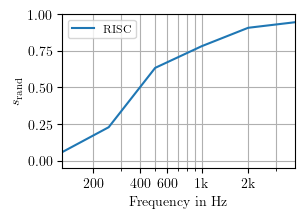

In [56]:
fig, ax = create_fig(figtype="stubby")
ax = pf.plot.freq(
    s_rand_orig_oct,
    dB=False, color='C0', linestyle='-',
    label='RISC')
ax.legend(fontsize=8)
ax.set_ylim((-0.05, 1))
ax.set_ylabel('$s_\mathrm{rand}$')
export_fig(fig,'Figure8b')



Illustration of the BSC- and RISC-based BRDF (in blue and orange, respectively)

**NOTE:** The RISC-based BRDF is scaled by a factor of 5 for visibility

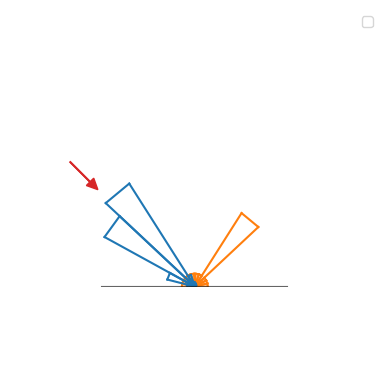

In [57]:
incident_direction = pf.Coordinates.from_spherical_colatitude(
    0, np.pi/4, 1)

i_in = directions_bsc.find_nearest(incident_direction)[0]

i_out = np.where(directions_bsc.y==0)[0]
i_out = i_out[np.argsort(directions_bsc[i_out].upper)]

for iband in [-1]:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='polar')
    delta_angle = 0.25094759
    ax.plot(
        [3*np.pi/4, 3*np.pi/4], [19, 16],
        color='C3', alpha=1,
        label='Incident direction',
    )
    for i_an in range(len(i_out)):
        center = np.pi-directions_bsc[i_out[i_an]].upper[0]
        lower = center - delta_angle/2
        upper = center + delta_angle/2

        brdf = brdf_RISC[i_in, i_out]
        norm = np.max(brdf.freq[:, iband])
        norm = .2
        old = brdf.freq[i_an, iband] / norm
        ax.plot(
            [lower, upper], [old, old],
            label=r'5$\times$RISC-based BRDF', c='C1')
        ax.plot(
            [lower, lower], [0, old],
            label='RISC-based BRDF', c='C1')
        ax.plot(
            [upper, upper], [0, old],
            label='RISC-based BRDF', c='C1')

    for i_an in range(len(i_out)):
        center = np.pi-directions_bsc[i_out[i_an]].upper[0]
        lower = center - delta_angle/2
        upper = center + delta_angle/2
        brdf = brdf_BSC[i_in, i_out]
        norm = np.max(brdf.freq[:, iband])
        norm = 1
        new = brdf.freq[i_an, iband] / norm
        ax.plot(
            [lower, upper], [new, new],
            label='BSC-based BRDF', c='C0', linestyle='-')
        ax.plot(
            [lower, lower], [0, new],
            label='BSC-based BRDF', c='C0', linestyle='-')
        ax.plot(
            [upper, upper], [0, new],
            label='BSC-based BRDF', c='C0', linestyle='-')

    ax.plot(
        [0, np.pi], [10, 10],
        color='k', alpha=1,
        label='Incident direction',
    )
    ax.arrow(
        3*np.pi/4, 19, 0, -3,
        color='C3', alpha=1,
        head_width=.07,
        head_length=1.2,
        linewidth=1,
        label='Incident direction',
    )
    ax.legend(fontsize=8)
    handles, labels = ax.get_legend_handles_labels()
    handles = np.array(handles)
    labels = np.array(labels)
    mask = np.zeros(len(handles), dtype=bool)
    mask[1] = True
    mask[-5] = True
    mask[0] = True
    ax.legend([])
    ff = frequencies_nom[iband]
    frequency_str = f'{ff/1000:.0f}kHz' if ff >=1e3 else f'{ff:.0f}Hz'
    ax.set_axis_off()
    ax.set_thetamax(180)
    export_fig(fig,'Figure8a')